In [19]:
import pandas as pd
import re
from transformers import pipeline

In [32]:
tesla_tweets = pd.read_csv('tesla_and_others.csv')

In [34]:
print(tesla_tweets.head())

                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  


In [35]:
tesla_tweets = tesla_tweets[tesla_tweets['Stock Name'] == 'TSLA']

In [36]:
print(tesla_tweets.head())
num_rows = tesla_tweets.shape[0]
print(f"Number of rows in the cleaned data: {num_rows}")

                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  
Number of rows in the cleaned data: 37422


In [42]:
tesla_tweets['Tweet'] = tesla_tweets['Tweet'].apply(lambda x: re.sub(r'http\S+|www.\S+|@\w+|#\w+', '', x))
tesla_tweets['Tweet'] = tesla_tweets['Tweet'].str.lower()

In [43]:
print(tesla_tweets['Tweet'].head())

0    mainstream media has done an amazing job at br...
1    tesla delivery estimates are at around 364k fr...
2    3/ even if i include 63.0m unvested rsus as of...
3       hahaha why are you still trying to stop tes...
4      stop trying to kill kids, you sad deranged o...
Name: Tweet, dtype: object


In [50]:
tesla_tweets['Date'] = pd.to_datetime(tesla_tweets['Date']).dt.date

In [51]:
print(tesla_tweets['Date'].head())

0    2022-09-29
1    2022-09-29
2    2022-09-29
3    2022-09-29
4    2022-09-29
Name: Date, dtype: object


In [57]:
tesla_tweets = tesla_tweets.dropna(subset=['Tweet', 'Date']).drop_duplicates()
tesla_tweets = tesla_tweets.drop_duplicates(subset='Tweet')
tesla_tweets = tesla_tweets.drop(columns=['Stock Name', 'Company Name'], errors='ignore')
print(tesla_tweets.head())

         Date                                              Tweet
0  2022-09-29  mainstream media has done an amazing job at br...
1  2022-09-29  tesla delivery estimates are at around 364k fr...
2  2022-09-29  3/ even if i include 63.0m unvested rsus as of...
3  2022-09-29     hahaha why are you still trying to stop tes...
4  2022-09-29    stop trying to kill kids, you sad deranged o...


In [58]:
num_rows = tesla_tweets.shape[0]
print(f"Number of rows in the cleaned data: {num_rows}")

Number of rows in the cleaned data: 37106


In [59]:
start_date = tesla_tweets['Date'].min()
end_date = tesla_tweets['Date'].max()

print(f"Start date of tweets: {start_date}")
print(f"End date of tweets: {end_date}")

Start date of tweets: 2021-09-30
End date of tweets: 2022-09-29


In [60]:
# load FinBERT model for sentiment analysis
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="yiyanghkust/finbert-tone",
    tokenizer="yiyanghkust/finbert-tone",
    device=0
)
# run sentiment classification on the 'Tweet' column in batches with truncation

sentiment_pipeline.tokenizer.model_max_length = 512
sentiment_pipeline.tokenizer.truncation = True
batch_size = 16
tweet_texts = tesla_tweets['Tweet'].tolist()  # convert text column to a list of tweets


sentiment_results = []
for i in range(0, len(tweet_texts), batch_size):
    batch = tweet_texts[i:i + batch_size]
    sentiments = sentiment_pipeline(batch, truncation=True)
    sentiment_results.extend(sentiments)

# add the sentiment labels back to the DataFrame
tesla_tweets['Sentiment'] = [result['label'] for result in sentiment_results]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [62]:
print(tesla_tweets.head())
sentiment_counts = tesla_tweets['Sentiment'].value_counts()
print(sentiment_counts)

         Date                                              Tweet Sentiment
0  2022-09-29  mainstream media has done an amazing job at br...  Positive
1  2022-09-29  tesla delivery estimates are at around 364k fr...   Neutral
2  2022-09-29  3/ even if i include 63.0m unvested rsus as of...   Neutral
3  2022-09-29     hahaha why are you still trying to stop tes...   Neutral
4  2022-09-29    stop trying to kill kids, you sad deranged o...   Neutral
Sentiment
Neutral     27413
Positive     6899
Negative     2794
Name: count, dtype: int64


In [135]:
tesla_stock_data = pd.read_csv('tesla_historical_stock_prices.csv')

In [136]:
print(tesla_stock_data.head())

        Date    Open    High     Low  Close   Adj Close       Volume
0  29-Sep-22  282.76  283.65  265.78  268.21      268.21  77,620,600
1  28-Sep-22  283.08  289.00  277.57  287.81      287.81  54,664,800
2  27-Sep-22  283.84  288.67  277.51  282.94      282.94  61,925,200
3  26-Sep-22  271.83  284.09  270.31  276.01      276.01  58,076,900
4  23-Sep-22  283.09  284.50  272.82  275.33      275.33  63,748,400


In [138]:
tesla_stock_data['Date'] = pd.to_datetime(tesla_stock_data['Date'], format='%d-%b-%y')
tesla_stock_data.columns = tesla_stock_data.columns.str.strip()
print(tesla_stock_data.columns)
tesla_stock_data = tesla_stock_data[['Date', 'Adj Close', 'Volume']].copy()
tesla_stock_data.rename(columns={'Adj Close': 'Price'}, inplace=True)

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [139]:
print(tesla_stock_data.head())

        Date   Price      Volume
0 2022-09-29  268.21  77,620,600
1 2022-09-28  287.81  54,664,800
2 2022-09-27  282.94  61,925,200
3 2022-09-26  276.01  58,076,900
4 2022-09-23  275.33  63,748,400


In [143]:
tesla_sentiment_data = tesla_tweets[['Date', 'Sentiment']]  # Assuming 'data' is your tweet DataFrame

# convert sentiment labels to numeric values
sentiment_mapping = {"Positive": 1, "Neutral": 0, "Negative": -1}
tesla_sentiment_data['sentiment_numeric'] = tesla_sentiment_data['Sentiment'].map(sentiment_mapping)
# make sure dates are in the right format
tesla_stock_data['Date'] = pd.to_datetime(tesla_stock_data['Date'])
tesla_sentiment_data['Date'] = pd.to_datetime(tesla_sentiment_data['Date'])
# aggregate sentiment scores by date (taking the average sentiment for each day)
daily_sentiment = tesla_sentiment_data.groupby('Date')['sentiment_numeric'].mean().reset_index()

daily_sentiment.rename(columns={'sentiment_numeric': 'daily_sentiment'}, inplace=True)
# interpolate missing prices
tesla_stock_data = tesla_stock_data.set_index('Date').asfreq('D')
tesla_stock_data = tesla_stock_data.infer_objects(copy=False)
tesla_stock_data['Price'] = pd.to_numeric(tesla_stock_data['Price'], errors='coerce')
tesla_stock_data['Volume'] = pd.to_numeric(tesla_stock_data['Volume'], errors='coerce')
tesla_stock_data = tesla_stock_data.interpolate().reset_index()
# merge Tesla stock data with sentiment data on date
merged_data = pd.merge(tesla_stock_data, daily_sentiment, on='Date', how='inner')

In [145]:
# Display all rows
pd.set_option('display.max_rows', None)

# Display all columns (optional, if you want to see all columns too)
pd.set_option('display.max_columns', None)

# Now print the DataFrame
print(merged_data)

# Reset display options to default (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

          Date       Price  Volume  daily_sentiment
0   2021-09-30  258.490000     NaN         0.133333
1   2021-10-01  258.410000     NaN         0.148936
2   2021-10-02  259.110000     NaN         0.295652
3   2021-10-03  259.810000     NaN         0.278689
4   2021-10-04  260.510000     NaN         0.169492
5   2021-10-05  260.200000     NaN         0.183908
6   2021-10-06  260.920000     NaN         0.142857
7   2021-10-07  264.540000     NaN         0.191176
8   2021-10-08  261.830000     NaN         0.147727
9   2021-10-09  262.546667     NaN         0.238095
10  2021-10-10  263.263333     NaN         0.206349
11  2021-10-11  263.980000     NaN         0.084211
12  2021-10-12  268.570000     NaN         0.105263
13  2021-10-13  270.360000     NaN         0.129412
14  2021-10-14  272.770000     NaN         0.179245
15  2021-10-15  281.010000     NaN         0.156028
16  2021-10-16  284.020000     NaN         0.054795
17  2021-10-17  287.030000     NaN         0.082474
18  2021-10-

In [151]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
def create_lagged_features(df, price_column, sentiment_column, n_lags=7):
    df = df.copy()
    for lag in range(1, n_lags + 1):
        df[f'price_lag_{lag}'] = df[price_column].shift(lag)
        df[f'sentiment_lag_{lag}'] = df[sentiment_column].shift(lag)
    return df
# create lagged features for n_lags days
n_lags = 7
print(merged_data.shape)
data_with_lags = create_lagged_features(merged_data, price_column='Price', sentiment_column='daily_sentiment', n_lags=n_lags)
data_with_lags = data_with_lags.iloc[n_lags:]
print(data_with_lags.shape)

# define features (X) and target (y)
X = data_with_lags[[col for col in data_with_lags.columns if 'lag' in col]]
#print(X.head())
y = data_with_lags['Price']

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# train the Linear Regression Model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# predict stock prices
y_pred = baseline_model.predict(X_test)

# calculate metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

(365, 4)
(358, 18)


In [152]:
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")

MAE: 4.784472221234635
RMSE: 6.755673019705904
R² Score: 0.761017946528974


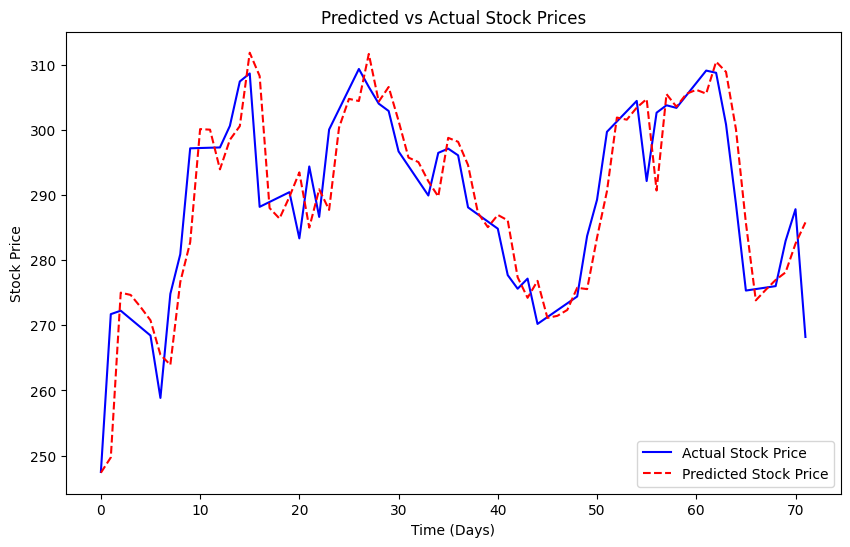

In [153]:
import matplotlib.pyplot as plt

# Plot the actual vs. predicted stock prices
plt.figure(figsize=(10, 6))

# Plot actual stock prices
plt.plot(y_test.values, label='Actual Stock Price', color='blue')

# Plot predicted stock prices
plt.plot(y_pred, label='Predicted Stock Price', color='red', linestyle='--')

# Add title and labels
plt.title("Predicted vs Actual Stock Prices")
plt.xlabel("Time (Days)")
plt.ylabel("Stock Price")
plt.legend()

# Show plot
plt.show()

